# Behavioral Cloning

## Load Data

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms as tfms
%matplotlib inline

In [2]:
# read the dataset
data_df = pd.read_csv('training_data_plains/driving_log.csv', header=None)

In [3]:
# def format_path(path):
#     return re.sub(re.escape(os.path.normpath("\\")), '/', path[31:])

In [4]:
# for i in range(3):
#     data_df[i] = data_df[i].map(format_path)

In [5]:
# get the center, left and right as X data and the steering angle as y data
X = data_df[[0,1,2]].values
y = data_df[3].values

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [7]:
print('Train Length:',len(X_train))
print('Val Length:',len(X_val))

Train Length: 14756
Val Length: 7268


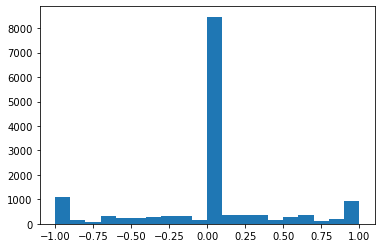

In [8]:
# steering angle histogram
plt.hist(y_train, bins=20)
plt.show()

## Data Preprocessing and Augmentation

* augmentation
    * choose center | left | right
    * flip
    * brightness
* preprocess
* batch generator

In [9]:
def choose_image(image_paths, steering_angle):
    '''Choose center | left | right and adjust the steering angle accordingly'''
    
    choice = np.random.choice(3)
    
    if choice == 0: # left
        return cv2.imread(image_paths[1].strip()), steering_angle + 0.2
    
    elif choice == 1: # right
        return cv2.imread(image_paths[2].strip()), steering_angle - 0.2
    
    return cv2.imread(image_paths[0].strip()), steering_angle # center

In [10]:
def random_flip(image, steering_angle):
    '''Randomly flip the image horizontally and adjust steering angle'''
    
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

In [11]:
def random_brightness(image):
    '''Randomly increase or decrease brightness'''
    
    choice = np.random.choice(2)
    
    if choice == 1:
        return image + np.random.randint(1,20)
    
    return image - np.random.randint(0,30)

In [12]:
def augmentation(image_paths, steering_angle):
    '''Generate an augmented image'''

    image, steering_angle = choose_image(image_paths, steering_angle)

    image, steering_angle = random_flip(image, steering_angle)
    image = random_brightness(image)
    
    return image, steering_angle

In [13]:
def preprocess_image(img):
    '''Preprocess an image by cropping, resizing and tensorizing'''
    img = img[60:-25,:]
    img = cv2.resize(img, (200, 66))
    img = tfms.ToTensor()(img)
    return img

In [14]:
def batch_generator(X_data, y_data, batch_size, is_training=True):
    '''Generate Training Data'''
    
    images = torch.empty([batch_size, 3, 66, 200])
    steers = torch.empty(batch_size)
    while True:
        i = 0
        for idx in np.random.permutation(X_data.shape[0]):
            image_paths = X_data[idx]
            steering_angle = y_data[idx]

            # randomly decide to augment or not
            if is_training and np.random.rand() < 0.5:
                image, steering_angle = augmentation(image_paths, steering_angle)
            else:
                image = cv2.imread(image_paths[0])

            images[i] = preprocess_image(image)
            steers[i] = steering_angle

            i += 1
            if i == batch_size:
                break
            
        yield images, steers

## Building the Model

In [15]:
class NvidiaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, 5, 2)
        self.conv2 = nn.Conv2d(24, 36, 5, 2)
        self.conv3 = nn.Conv2d(36, 48, 5, 2)
        self.conv4 = nn.Conv2d(48, 64, 3, 1)
        self.conv5 = nn.Conv2d(64, 64, 3, 1)
        
        self.dense = nn.Sequential(nn.Linear(1152, 100),
                                   nn.ELU(),
                                   nn.Dropout(0.25),
                                   nn.Linear(100, 50),
                                   nn.ELU(),
                                   nn.Linear(50, 10),
                                   nn.ELU(),
                                   nn.Linear(10, 1))
    
    def forward(self, x):
        
        batch_size = x.size(0)
        
        # Convolutional Pass
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        
        # Linear Pass
        x = x.reshape(batch_size, -1)
        out = self.dense(x)
        
        return out

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
model = NvidiaModel()

## Train Model

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=2)

In [19]:
from time import time

In [20]:
def train(model,
          criterion,
          optimizer, 
          scheduler,
          tag,
          train_steps=5000,
          validation_steps=1000,
          batch_size=32,
          epochs=10,
          device='cuda'):
    
    # push to model to the device (CUDA or CPU)
    model.to(device)
    
    # Create Data Generators
    train_loader = batch_generator(X_train, y_train, batch_size)
    val_loader = batch_generator(X_val, y_val, batch_size, is_training=False)
    
    # Directory for saving model
    if not os.path.isdir('models'):
        os.mkdir('models')
    
    for current_epoch in range(1, epochs+1):
        
        # TRAIN
        pbar = tqdm(desc=f"Training Epoch {current_epoch}", total=train_steps)
        model.train()
        
        for i in range(train_steps):
            images, steers = next(train_loader)
            
            images = images.to(device)
            steers = steers.to(device)
            
            # set the optimizer to zero gradients
            optimizer.zero_grad()
            
            # pass the inputs through the model
            outputs = model(images)

            # calculate loss
            loss = criterion(outputs.squeeze(1), steers)
            # backpropagate
            loss.backward()
            # optimize
            optimizer.step()
            
            pbar.set_postfix({
                'Train Loss': loss.item()
            })
            pbar.update(1)
        
        pbar.close()
        
        # VALIDATION
        model.eval()
        
        with torch.no_grad():
            
            val_pbar = tqdm(desc=f"Validation Epoch {current_epoch}", total=validation_steps)
            
            val_losses = []
            
            for i in range(validation_steps):
                images, steers = next(val_loader)
                # move the data to selected device
                images = images.to(device)
                steers = steers.to(device)

                # pass the inputs through the model
                outputs = model(images)

                # calculate loss
                loss = criterion(outputs.squeeze(1), steers)
                val_losses.append(loss.item())
                
                val_pbar.set_postfix({
                    'Val Loss': loss.item()
                })
                val_pbar.update(1)
            
            mean_val_loss = sum(val_losses)/len(val_losses)
        
        val_pbar.set_postfix({
            'Avg Val Loss': mean_val_loss
        })
        val_pbar.close()
        
        # Save model
        torch.save(model.state_dict(), f'models/model-{current_epoch}-{tag}.pth')
    
        scheduler.step()

In [ ]:
%%time
train(model, criterion, optimizer, scheduler, tag='plains', epochs=10, device=device)